In [31]:
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import deque

class ReflectionMap():
    def __init__(self,model_type='vit_b',model_path='./model_path/sam_vit_b_01ec64.pth',device='cuda'):
        sam = sam_model_registry[model_type](checkpoint=model_path).to(device)
        self.predictor = SamPredictor(sam)
    def set_image(self, image_path,plot=True):
        image = cv2.imread(image_path)
        self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.predictor.set_image(self.image)
        if plot:
            plt.figure(figsize=(10,10))
            plt.imshow(self.image)
            plt.axis('on')
            plt.show()
    def _show_mask(self,mask,ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)
    def _show_points(self,coords, labels, ax, marker_size=375):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)  
    def _show_box(self,box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    def parse_mask(self,mask, src_point):
        h, w = mask.shape
        src_x, src_y = src_point

        # Check if the source point is valid
        assert mask[src_y, src_x] == 1, "Source point is not in the mask"

        # Create a visited array to keep track of visited points
        visited = np.zeros_like(mask, dtype=bool)

        # Initialize a queue for BFS and add the source point
        queue = deque([(src_x, src_y)])

        # BFS to find all connected points
        while queue:
            x, y = queue.popleft()
            if visited[y, x]:
                continue

            visited[y, x] = True

            # Check and add neighboring points
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < w and 0 <= ny < h and mask[ny, nx] == 1 and not visited[ny, nx]:
                    queue.append((nx, ny))

        # Set non-visited points to 0
        mask[~visited] = 0

        return mask
    def find_most_similar_part(self,image, mask,src_point):
        # Find bounding box of the mask
        y_indices, x_indices = np.where(mask == 1)
        h_min, h_max = y_indices.min(), y_indices.max()
        w_min, w_max = x_indices.min(), x_indices.max()

        # give relative distance
        src_center_h=(h_min+h_max)/2
        src_center_w=(w_max+w_min)/2
        src_w,src_h=src_point
        relative=(src_w-src_center_w,src_h-src_center_h)
        # Crop and vertically flip the template image
        template = image[h_min:h_max+1, w_min:w_max+1]
        template = cv2.flip(template, 0)

        # Define sub-part of the image to search
        search_part = image[h_max:,w_min:w_max+1]

        # Template matching
        res = cv2.matchTemplate(search_part, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # Find the center of the matched area in the search_part
        matched_top_left = max_loc
        h, w, _ = template.shape
        matched_center = (matched_top_left[0] + w // 2, matched_top_left[1] + h // 2)
        
        # Adjust the matched center to the coordinates of the original image
        original_center = (matched_center[0] + w_min, matched_center[1] + h_max)
        
        # Adjust with the relative distance
        tar_w = original_center[0] + relative[0]
        tar_h = original_center[1] - relative[1]
        return [tar_w, tar_h]
    def get_relection(self,input_point,plot=True):
        input_point=np.array([input_point])
        masks, scores, logits = self.predictor.predict(
        point_coords=input_point,
        point_labels=np.array([1]),
        multimask_output=True,
        )
        mask=masks[0]
        score=scores[0]
        mask=self.parse_mask(mask,input_point[0])
        if plot:
            plt.figure(figsize=(10,10))
            plt.imshow(self.image)
            self._show_mask(mask, plt.gca())
            self._show_points(input_point, np.array([1]), plt.gca())
            plt.axis('on')
            plt.show()  
        
        tar=self.find_most_similar_part(self.image,mask,input_point[0])
        
        if plot:
            plt.figure(figsize=(10,10))
            plt.imshow(self.image)
            self._show_points(np.array([input_point[0],tar]), np.array([1,0]), plt.gca())
            plt.axis('on')
            plt.show()  
    

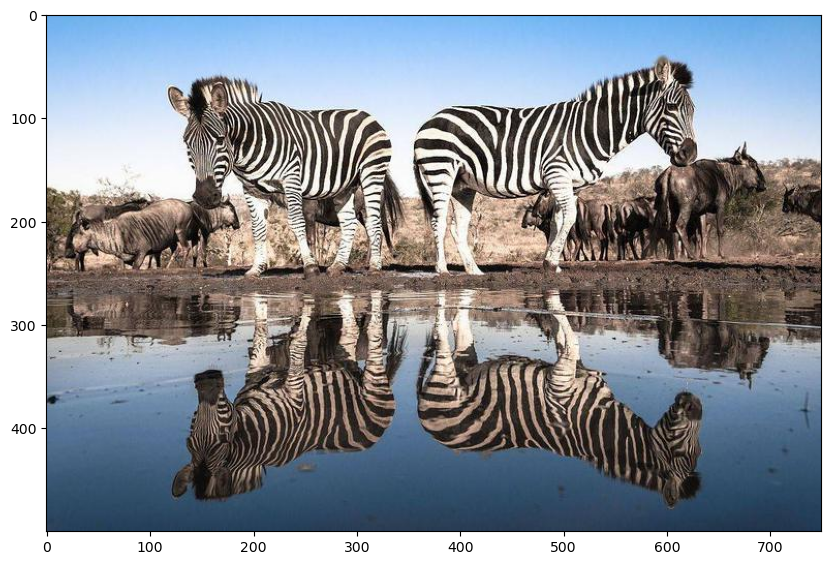

In [32]:
image_path='./dataset/image_101.jpg'
reflection_mapper=ReflectionMap()
reflection_mapper.set_image(image_path)

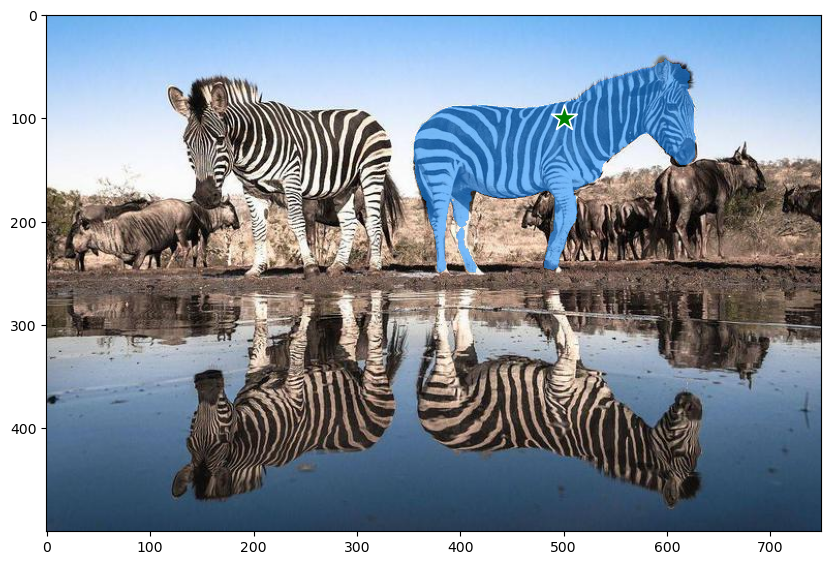

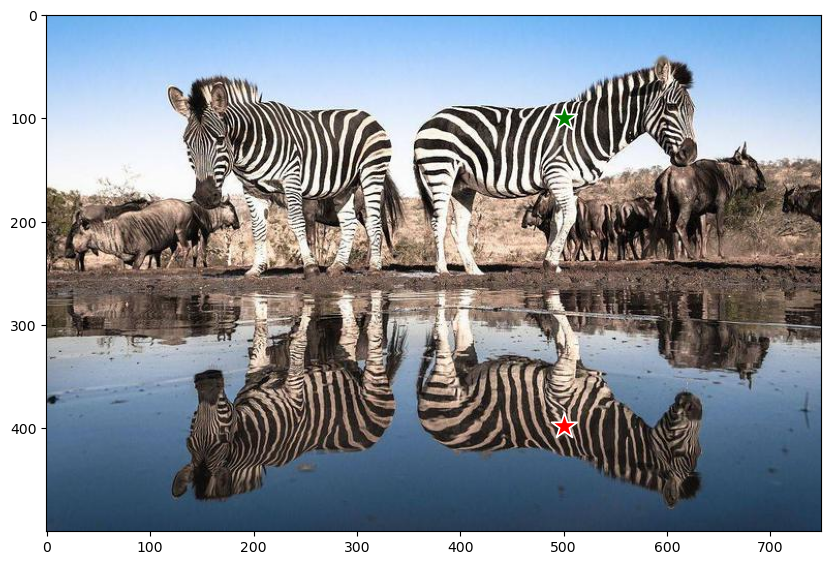

In [33]:
reflection_mapper.get_relection([500,100])